In [1]:
import numpy as np
from scipy import optimize
from numba import vectorize
import torch
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['science','notebook'])

import sys
sys.path.insert(0, '../src/pydftlj/')
from dft3dgpu import dft3d
from eos import LJEOS 

from pymatgen.core import Structure
from pymatgen.analysis import structure_matcher

# Author: Elvis do A. Soares
# Github: @elvissoares
# Date: 2023-05-03

In [2]:
kB = 1.380649e-23 # J/K
Rconst = 0.082057366080960 # Gas constant
NA = 6.022e23 # Avogadro number

## Solid CIF file Information

In [3]:
structure_name = 'MOF-5'
structure = Structure.from_file('../structures/'+structure_name+'.cif')
Ncell = 2
structure.make_supercell(Ncell)
print('formula:  ', structure.formula)
print('num_sites:', structure.num_sites)

formula:   Zn256 H768 C1536 O832
num_sites: 3392


In [4]:
coordinates = structure.cart_coords.T
L = np.array([l/Ncell for l in structure.lattice.lengths])
print('Cell dimensions: ', L)
Vcell = L[0]*L[1]*L[2]
print('Cell volume: ', Vcell)

Cell dimensions:  [25.86584 25.86584 25.86584]
Cell volume:  17305.325019903623


# Force Field for solid-fluid interaction

In [5]:
forcefield_name = 'DREIDING'
forcefield = pd.read_csv('../parameters/'+forcefield_name+'-forcefield.dat',delim_whitespace=True)
forcefield

,atom,sigma/AA,epsilon/kB,mass/u
0,H,2.84642,7.64893,1.00784
1,C,3.47299,47.85620,12.01070
2,N,3.26256,38.94920,14.00670
3,O,3.03315,48.15810,15.99900
4,Cu,3.11369,2.51610,63.54600
5,Zn,4.04468,27.67710,65.38000


# Fluid Information

In [6]:
# PCSAFT: Gross, J., & Sadowski, G. (2001). Industrial & Engineering Chemistry Research, 40(4), 1244–1260.
fluid_molecule = 'H2'
epsilon = {'Buch': 34.20, 'Buch2': 36.7}
sigma = {'Buch': 2.96, 'Buch2': 2.96}

fluid_forcefield = 'Buch'
epsilonff = epsilon[fluid_forcefield]  # kelvin
sigmaff = sigma[fluid_forcefield]  # angstrom
mff = 2.016

In [7]:
#Helium parameters for pycnometer
epsilonHe = 10.22 # kelvin
sigmaHe = 2.58  # angstrom

# Create the DFT object

In [97]:
Ngrid = 128
DFT = dft3d(gridsize=np.array([Ngrid,Ngrid,Ngrid]),ljmethod='MMFA')
DFT.Set_Geometry(L)

In [98]:
DFT.GetSystemInformation()

============== The DFT 3D for LJ fluids ==============
Methods:
The grid is [128 128 128]
--- Geometry properties ---
Lx = 25.86584  A
Ly = 25.86584  A
Lz = 25.86584  A
Vol = 17305.325019903623  A³


In [99]:
DFT.Set_FluidProperties(sigma=sigmaff,epsilon=epsilonff)

In [100]:
DFT.GetFluidInformation()

--- Fluid properties ---
epsilon/kB = 34.2  K
sigma = 2.96  A


## Generating the External Potential

In [101]:
@vectorize
def ljpotential(r,eps,sigma):
    return 4*eps*((sigma/r)**(12)-(sigma/r)**(6))

In [102]:
%%time

mss = 0.0

Vext = np.zeros((Ngrid,Ngrid,Ngrid))
Vext_helium = np.zeros((Ngrid,Ngrid,Ngrid))

# Lorentz-Berthelot combination rule
for i, site in enumerate(structure):
    sigmasf = float(0.5*(sigmaff+forcefield["sigma/AA"][forcefield["atom"]==site.species_string]))
    epsilonsf = float(np.sqrt(epsilonff*forcefield["epsilon/kB"][forcefield["atom"]==site.species_string]))
    mss += float(forcefield["mass/u"][forcefield["atom"]==site.species_string])

    R = np.sqrt((DFT.X-structure.cart_coords[i,0]+L[0])**2 + (DFT.Y-structure.cart_coords[i,1]+L[1])**2 + (DFT.Z-structure.cart_coords[i,2]+L[2])**2)
    Vext[:] += ljpotential(R,epsilonsf,sigmasf)

    sigmasHe = float(0.5*(sigmaHe+forcefield["sigma/AA"][forcefield["atom"]==site.species_string]))
    epsilonsHe = float(np.sqrt(epsilonHe*forcefield["epsilon/kB"][forcefield["atom"]==site.species_string]))

    Vext_helium[:] += ljpotential(R,epsilonsHe,sigmasHe)

mss = mss/(Ncell**3)

del R

DFT.Set_External_Potential(Vext)

CPU times: user 2min 4s, sys: 128 ms, total: 2min 4s
Wall time: 2min 4s


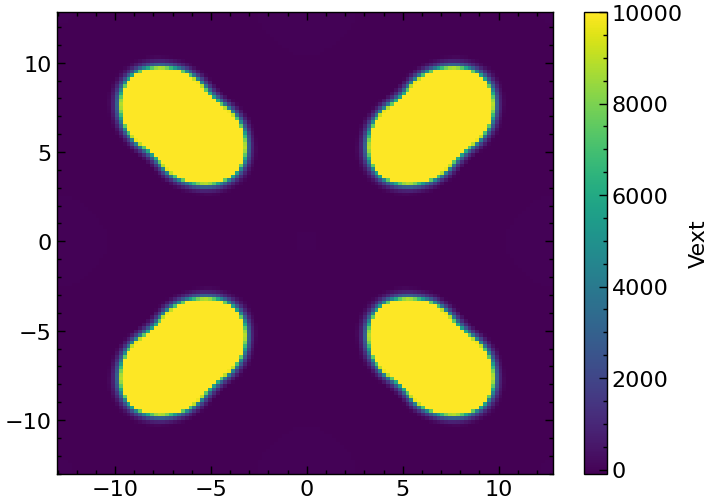

In [103]:
plt.figure(figsize=(8,6))
c=plt.pcolormesh(DFT.X[:,:,Ngrid//2],DFT.Y[:,:,Ngrid//2],DFT.Vext[:,:,Ngrid//2].cpu(), cmap='viridis',vmin=-1e2,vmax=1e4)
plt.colorbar(label='Vext')
plt.show()

In [104]:
print('Unit cell mass: ', mss, ' u')

Unit cell mass:  6158.863039999983  u


In [105]:
rhocr = 1e27*mss/(Vcell*NA) #kg/m3 crystal MOF-5 density

In [106]:
print('Crystal Density: ',rhocr,' kg/m3')

Crystal Density:  590.9898672923852  kg/m3


In [107]:
Vpore_calc = np.exp(-Vext_helium/298.15).sum()*DFT.dV

print(f'Calculated He pore volume is {Vpore_calc:1.3f} A³')

helium_fraction = Vpore_calc/Vcell

print(f'Calculated He void fraction is {helium_fraction:1.3f}')

Calculated He pore volume is 13947.458 A³
Calculated He void fraction is 0.806


## Defining the Temperature

In [108]:
kT = 300.0 # kelvin 
DFT.Set_Temperature(kT)

In [109]:
DFT.GetFluidTemperatureInformation()

Temperature = 300.0  K
Baker-Henderson diameter = 2.679  A


In [110]:
Vpore_fluid = np.exp(-DFT.beta*Vext).sum()*DFT.dV

print(f'Calculated fluid pore volume is {Vpore_calc} A³')

Calculated fluid pore volume is 13947.458038604898 A³


In [111]:
ljeos= LJEOS(sigma=sigmaff,epsilon=epsilonff,model='MBWR')

In [112]:
def rhofromBARpressure(pbar):
    def func(x,p):
        return ljeos.p(x,kT)-p,ljeos.dpdrho(x,kT), ljeos.d2pdrho2(x,kT)
    if np.isscalar(pbar):
        sol = optimize.root_scalar(func, x0=1e-2, fprime=True,fprime2=True,args=(1e-30*pbar/(1e-5*kB)), method='halley')
        rho = sol.root
    else:
        rho = np.empty_like(pbar)
        sol = optimize.root_scalar(func, x0=1e-2, fprime=True,fprime2=True,args=(1e-30*pbar[0]/(1e-5*kB)), method='halley')
        rho[0] = sol.root
        for i in range(1,pbar.size):
            sol = optimize.root_scalar(func, x0=rho[i-1], fprime=True,fprime2=True,args=(1e-30*pbar[i]/(1e-5*kB)), method='halley')
            rho[i] = sol.root
    return rho

In [113]:
pbararray = np.hstack((np.arange(0.1,2.0,0.1),np.arange(2.,101,1.0),np.arange(110,510,10.0))) # bulk pressure (in bar)
# pbararray = np.hstack((np.arange(0.1,2.0,0.1),np.arange(2.,101,1.0)))

In [114]:
rhobarray = rhofromBARpressure(pbararray)

Text(0, 0.5, '$\\rho_b$ (molecules/$\\AA^{3}$)')

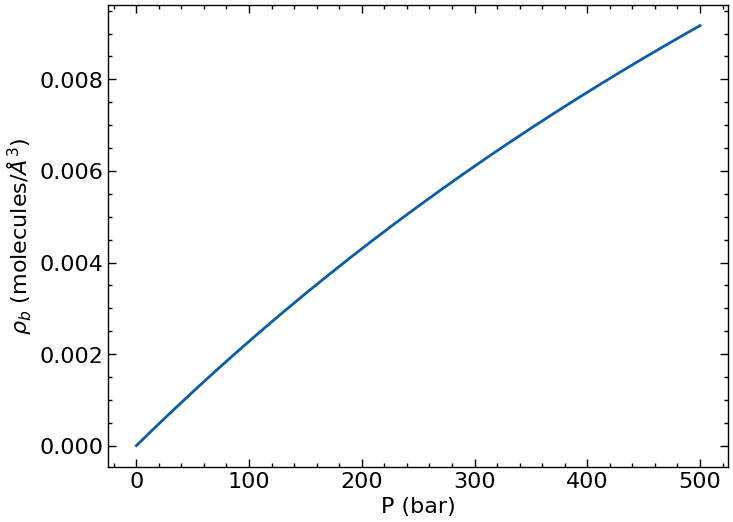

In [115]:
plt.plot(pbararray,rhobarray)
plt.xlabel(r'P (bar)')
plt.ylabel(r'$\rho_b$ (molecules/$\AA^{3}$)')

In [116]:
%%time

Nbulkarray = np.zeros_like(rhobarray)
Nidearray = np.zeros_like(rhobarray)
Nadsarray = np.zeros_like(rhobarray)
Nexcarray = np.zeros_like(rhobarray)

DFT.Set_BulkDensity(rhobarray[0])
DFT.Set_InitialCondition()

print('P (bar)\t rhob (AA^-3)\t Nabs(molecules/u.c.)')

for i in range(rhobarray.size):
    rhob = rhobarray[i]

    DFT.Set_BulkDensity(rhob)

    # DFT.Calculate_Equilibrium(alpha0=0.25,dt=0.2,rtol=1e-4,atol=1e-6,method='fire',logoutput=False)
    DFT.Calculate_Equilibrium(alpha0=0.1,dt=0.1,rtol=1e-4,atol=1e-6,method='fire',logoutput=False)

    if (pbararray[i]==10.0) or (pbararray[i]==30.0) or (pbararray[i]==60.0):
        np.save(f"dft-profile-{structure_name}-{fluid_molecule}-{fluid_forcefield}-{forcefield_name}-P={pbararray[i]}bar-T={kT}K-N={Ngrid}-ljmethod={DFT.ljmethod}.npy",DFT.rho.numpy())

    Nbulkarray[i] = DFT.rhob*Vpore_calc
    Nidearray[i] = DFT.rhob*Vpore_fluid
    Nadsarray[i] = DFT.Nabs
    Nexcarray[i] = Nadsarray[i] - Nbulkarray[i]
    print(pbararray[i].round(2),rhob.round(4),Nidearray[i].round(3),Nadsarray[i].round(3),Nexcarray[i].round(3))

/home/elvis/Google Drive/Projetos em Andamento/2-DFT in Amorphous Carbon/codes/PyDFTlj/examples/../src/pydftlj/dft3dgpu.py:179: RuntimeWarning: invalid value encountered in dphi3dnfuncWBI
  self.dphi3dn3 = torch.tensor(dphi3dnfuncWBI(self.n3.numpy()),dtype=torch.float32)


P (bar)	 rhob (AA^-3)	 Nabs(molecules/u.c.)
0.1 0.0 0.049 0.039 0.005
0.2 0.0 0.097 0.091 0.024
0.3 0.0 0.146 0.135 0.034
0.4 0.0 0.195 0.183 0.048
0.5 0.0 0.243 0.232 0.063
0.6 0.0 0.292 0.28 0.078
0.7 0.0 0.34 0.329 0.094
0.8 0.0 0.389 0.378 0.109
0.9 0.0 0.438 0.427 0.124
1.0 0.0 0.486 0.475 0.139
1.1 0.0 0.535 0.524 0.153
1.2 0.0 0.583 0.572 0.168
1.3 0.0 0.632 0.621 0.183
1.4 0.0 0.68 0.669 0.198
1.5 0.0 0.729 0.718 0.213
1.6 0.0 0.778 0.766 0.228
1.7 0.0 0.826 0.814 0.243
1.8 0.0 0.875 0.863 0.257
1.9 0.0 0.923 0.911 0.272
2.0 0.0 0.972 0.96 0.287
3.0 0.0001 1.457 1.442 0.433
4.0 0.0001 1.941 1.924 0.58
5.0 0.0001 2.425 2.404 0.725
6.0 0.0001 2.908 2.882 0.868
7.0 0.0002 3.391 3.359 1.011
8.0 0.0002 3.873 3.834 1.152
9.0 0.0002 4.355 4.307 1.292
10.0 0.0002 4.836 4.779 1.431
11.0 0.0003 5.317 5.249 1.568
12.0 0.0003 5.797 5.718 1.705
13.0 0.0003 6.276 6.185 1.84
14.0 0.0003 6.755 6.651 1.974
15.0 0.0004 7.233 7.115 2.107
16.0 0.0004 7.711 7.578 2.239
17.0 0.0004 8.189 8.039 2.37


KeyboardInterrupt: 

In [ ]:
# helium_void_fraction = Vpore/Vcell
helium_void_fraction = 0.852
# helium_void_fraction = 0.815

Vpore = helium_void_fraction*Vcell
Vpore

14744.136916957887

In [ ]:
Marray = mff*Nadsarray

Nbulkarray = rhobarray*Vpore_calc
Mbulk = mff*Nbulkarray

In [ ]:
Midealarray = mff*Nidearray

In [ ]:
Mexcarray = Nexcarray*mff

In [ ]:
df = pd.DataFrame()
df['Pressure (bar)'] = pbararray
df['Bulk adsorption (molecules/uc)'] = Nbulkarray
df['Bulk adsorption (%w.t.)'] = 100*Mbulk/(mss+Mbulk)
df['Bulk adsorption (cm^3 STP/cm^3)'] = 1e30*(kB*273.15/1e5)*Nbulkarray/Vcell 
df['Bulk adsorption (mol/kg)'] = 1e3*Nbulkarray/mss
df['Ideal adsorption (molecules/uc)'] = Nidearray
df['Ideal adsorption (%w.t.)'] = 100*Midealarray/(mss+Midealarray)
df['Ideal adsorption (cm^3 STP/cm^3)'] = 1e30*(kB*273.15/1e5)*Nidearray/Vcell
df['Ideal adsorption (mol/kg)'] = 1e3*Nidearray/mss
df['Absolute adsorption (molecules/uc)'] = Nadsarray
df['Absolute adsorption (mg/g)'] = 1e3*Marray/mss
df['Absolute adsorption (%w.t.)'] = 100*Marray/(mss+Marray)
df['Absolute adsorption (mol/kg)'] = 1e3*Nadsarray/mss
df['Absolute adsorption (cm^3 STP/cm^3)'] = 1e30*(kB*273.15/1e5)*Nadsarray/Vcell # STP 0ºC and 1e5 Pa (IUPAC since 1982)
df['Excess adsorption (molecules/uc)'] = Nexcarray
df['Excess adsorption (mg/g)'] = 1e3*Mexcarray/mss
df['Excess adsorption (%w.t.)'] = 100*Mexcarray/(mss+Mexcarray)
df['Excess adsorption (mol/kg)'] = 1e3*Nexcarray/mss
df['Excess adsorption (cm^3 STP/cm^3)'] = 1e30*(kB*273.15/1e5)*Nexcarray/Vcell

In [ ]:
df.head()

,Pressure (bar),Bulk adsorption (molecules/uc),Bulk adsorption (%w.t.),Bulk adsorption (cm^3 STP/cm^3),Bulk adsorption (mol/kg),Ideal adsorption (molecules/uc),Ideal adsorption (%w.t.),Ideal adsorption (cm^3 STP/cm^3),Ideal adsorption (mol/kg),Absolute adsorption (molecules/uc),Absolute adsorption (mg/g),Absolute adsorption (%w.t.),Absolute adsorption (mol/kg),Absolute adsorption (cm^3 STP/cm^3),Excess adsorption (molecules/uc),Excess adsorption (mg/g),Excess adsorption (%w.t.),Excess adsorption (mol/kg),Excess adsorption (cm^3 STP/cm^3)
0,0.1,0.033681,0.001102,0.073400,0.005469,0.048649,0.001592,0.106019,0.007899,0.039061,0.012786,0.001279,0.006342,0.085123,0.005380,0.001761,0.000176,0.000873,0.011724
1,0.2,0.067359,0.002205,0.146791,0.010937,0.097293,0.003185,0.212025,0.015797,0.091207,0.029855,0.002985,0.014809,0.198762,0.023848,0.007806,0.000781,0.003872,0.051971
2,0.3,0.101032,0.003307,0.220174,0.016404,0.145931,0.004777,0.318019,0.023695,0.134747,0.044107,0.004411,0.021879,0.293646,0.033715,0.011036,0.001104,0.005474,0.073472
3,0.4,0.134702,0.004409,0.293548,0.021871,0.194564,0.006368,0.424002,0.031591,0.182790,0.059833,0.005983,0.029679,0.398343,0.048088,0.015741,0.001574,0.007808,0.104794
4,0.5,0.168368,0.005511,0.366914,0.027338,0.243191,0.007960,0.529972,0.039486,0.231643,0.075824,0.007582,0.037611,0.504806,0.063275,0.020712,0.002071,0.010274,0.137891


(0.0, 50.0)

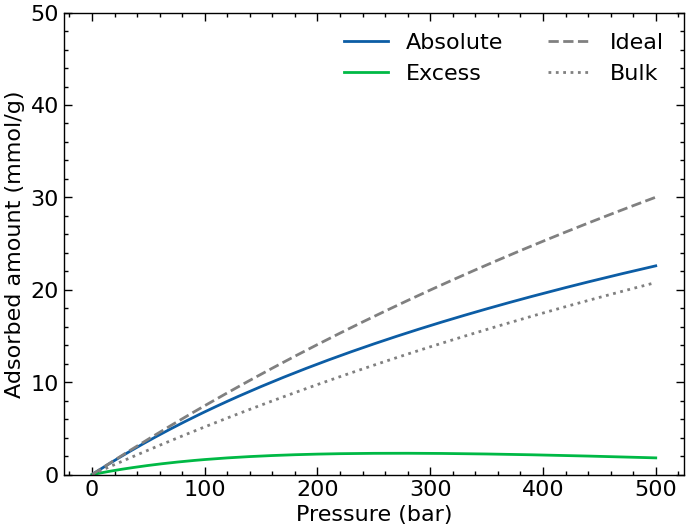

In [ ]:
plt.plot(df['Pressure (bar)'],df['Absolute adsorption (mol/kg)'],label='Absolute')
plt.plot(df['Pressure (bar)'],df['Excess adsorption (mol/kg)'],label='Excess')
plt.plot(df['Pressure (bar)'],df['Ideal adsorption (mol/kg)'],'--',color='grey',label='Ideal')
plt.plot(df['Pressure (bar)'],df['Bulk adsorption (mol/kg)'],':',color='grey',label='Bulk')
plt.legend(loc='best',ncol=2)
plt.ylabel('Adsorbed amount (mmol/g)')
plt.xlabel('Pressure (bar)')
plt.ylim(0,50)

In [ ]:
df.to_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-'+fluid_forcefield+'-'+forcefield_name+'-T='+str(kT)+'K-N='+str(Ngrid)+'-ljmethod='+str(DFT.ljmethod)+'.dat', index=False,sep='\t')

In [ ]:
# dft200K_data = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-TraPPE-DREIDING-T=200.0K-N=64-ljmethod=MMFA.dat',sep='\t')
dft125K_data = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-Buch-DREIDING-T=125.0K-N=64-ljmethod=MMFA.dat',sep='\t')
dft200K_data = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-Buch-DREIDING-T=200.0K-N=64-ljmethod=MMFA.dat',sep='\t')
dft300K_data = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-Buch-DREIDING-T=300.0K-N=64-ljmethod=MMFA.dat',sep='\t')

dft77K_data32 = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-Buch-DREIDING-T=77.0K-N=32-ljmethod=MMFA.dat',sep='\t')
dft100K_data32 = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-Buch-DREIDING-T=100.0K-N=32-ljmethod=MMFA.dat',sep='\t')
dft125K_data32 = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-Buch-DREIDING-T=125.0K-N=32-ljmethod=MMFA.dat',sep='\t')
dft200K_data32 = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-Buch-DREIDING-T=200.0K-N=32-ljmethod=MMFA.dat',sep='\t')
dft300K_data32 = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-Buch-DREIDING-T=300.0K-N=32-ljmethod=MMFA.dat',sep='\t')

# Plotting the results

In [ ]:
exp_data = pd.read_excel('data/experimental/H2andCH4-MOFandZIF-isotherm-Zhou2007.xls',sheet_name='H2-MOF5-Absolute')
exp_data_exc = pd.read_excel('data/experimental/H2andCH4-MOFandZIF-isotherm-Zhou2007.xls',sheet_name='H2-MOF5-Excess')
exp_data2p5 = pd.read_excel('data/experimental/H2-MOF-isotherm-Kaye2007.xls',sheet_name='IRMOF-1')

(0.0, 10.0)

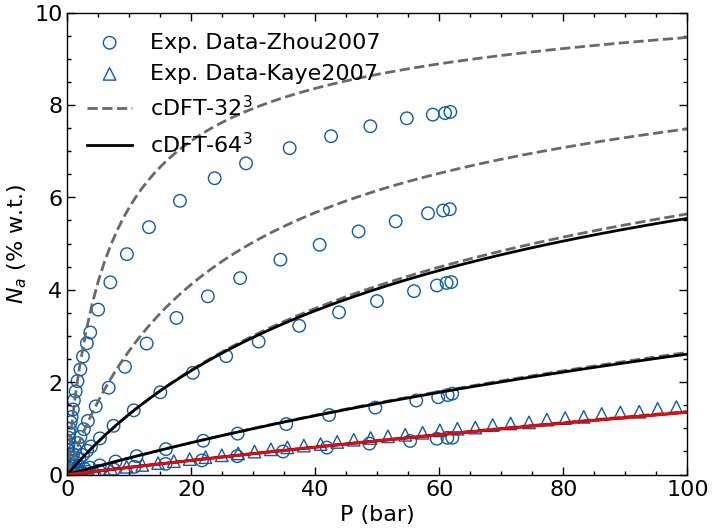

In [ ]:
plt.rcParams["lines.markersize"] = 9

plt.scatter(exp_data['P(bar)-300K'],exp_data['Na(%wt)-300K'],marker='o',edgecolors='C0',facecolors='none',label='Exp. Data-Zhou2007')
plt.scatter(exp_data['P(bar)-200K'],exp_data['Na(%wt)-200K'],marker='o',edgecolors='C0',facecolors='none')
plt.scatter(exp_data['P(bar)-125K'],exp_data['Na(%wt)-125K'],marker='o',edgecolors='C0',facecolors='none')
plt.scatter(exp_data['P(bar)-100K'],exp_data['Na(%wt)-100K'],marker='o',edgecolors='C0',facecolors='none')
plt.scatter(exp_data['P(bar)-77K'],exp_data['Na(%wt)-77K'],marker='o',edgecolors='C0',facecolors='none')

plt.scatter(exp_data2p5['P (bar)'],exp_data2p5['Total H2 adsorbed (wt %)'],marker='^',edgecolors='C0',facecolors='none',label='Exp. Data-Kaye2007')

plt.plot(dft77K_data32['Pressure (bar)'],dft77K_data32['Absolute adsorption (%w.t.)'],'--',color='dimgrey')
plt.plot(dft100K_data32['Pressure (bar)'],dft100K_data32['Absolute adsorption (%w.t.)'],'--',color='dimgrey')
plt.plot(dft125K_data32['Pressure (bar)'],dft125K_data32['Absolute adsorption (%w.t.)'],'--',color='dimgrey')
plt.plot(dft200K_data32['Pressure (bar)'],dft200K_data32['Absolute adsorption (%w.t.)'],'--',color='dimgrey')
plt.plot(dft300K_data32['Pressure (bar)'],dft300K_data32['Absolute adsorption (%w.t.)'],'--',color='dimgrey',label='cDFT-32$^3$')

# plt.plot(dft240K_data['Pressure (bar)'],dft240K_data['Absolute adsorption (%w.t.)'],'-',color='k')
plt.plot(dft125K_data['Pressure (bar)'],dft125K_data['Absolute adsorption (%w.t.)'],'-',color='k')
plt.plot(dft300K_data['Pressure (bar)'],dft300K_data['Absolute adsorption (%w.t.)'],'-',color='k',label='cDFT-64$^3$')
plt.plot(dft200K_data['Pressure (bar)'],dft200K_data['Absolute adsorption (%w.t.)'],'-',color='k')

plt.plot(df['Pressure (bar)'],df['Absolute adsorption (%w.t.)'],'-',color='red')

plt.legend(loc='upper left')
plt.xlabel('P (bar)')
plt.ylabel('$N_a$ (% w.t.)')
plt.xlim(0,100)
# plt.ylim(0,2)
plt.ylim(0,10)

(0.0, 7.0)

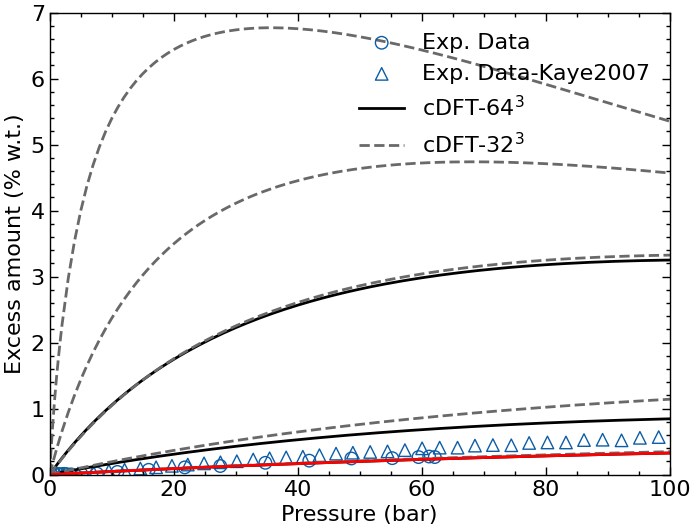

In [ ]:
plt.rcParams["lines.markersize"] = 9

plt.scatter(exp_data_exc['P(bar)-300K'],exp_data_exc['Nexc(%wt)-300K'],marker='o',edgecolors='C0',facecolors='none',label='Exp. Data')
# plt.scatter(exp_data['Pexc(bar)-270K'],exp_data['Nexc(%wt)-270K'],marker='o',edgecolors='C0',facecolors='none')
# plt.scatter(exp_data['Pexc(bar)-240K'],exp_data['Nexc(%wt)-240K'],marker='o',edgecolors='C0',facecolors='none')
# plt.scatter(exp_data['Pexc(bar)-200K'],exp_data['Nexc(%wt)-200K'],marker='o',edgecolors='C0',facecolors='none')
# plt.scatter(exp_data['Pexc(bar)-150K'],exp_data['Nexc(%wt)-150K'],marker='o',edgecolors='C0',facecolors='none')

plt.scatter(exp_data2p5['P (bar)'],exp_data2p5['Excess H2 adsorbed (wt %)'],marker='^',edgecolors='C0',facecolors='none',label='Exp. Data-Kaye2007')

# plt.plot(dft240K_data['Pressure (bar)'],dft240K_data['Excess adsorption (%w.t.)'],'-',color='k')
plt.plot(dft125K_data['Pressure (bar)'],dft125K_data['Excess adsorption (%w.t.)'],'-',color='k')
plt.plot(dft200K_data['Pressure (bar)'],dft200K_data['Excess adsorption (%w.t.)'],'-',color='k')
plt.plot(dft300K_data['Pressure (bar)'],dft300K_data['Excess adsorption (%w.t.)'],'-',color='k',label='cDFT-64$^3$')

plt.plot(dft77K_data32['Pressure (bar)'],dft77K_data32['Excess adsorption (%w.t.)'],'--',color='dimgrey')
plt.plot(dft100K_data32['Pressure (bar)'],dft100K_data32['Excess adsorption (%w.t.)'],'--',color='dimgrey')
plt.plot(dft125K_data32['Pressure (bar)'],dft125K_data32['Excess adsorption (%w.t.)'],'--',color='dimgrey')
plt.plot(dft200K_data32['Pressure (bar)'],dft200K_data32['Excess adsorption (%w.t.)'],'--',color='dimgrey')
plt.plot(dft300K_data32['Pressure (bar)'],dft300K_data32['Excess adsorption (%w.t.)'],'--',color='dimgrey',label='cDFT-32$^3$')

plt.plot(df['Pressure (bar)'],df['Excess adsorption (%w.t.)'],'-',color='red')

plt.legend(loc='upper right')
plt.xlabel('Pressure (bar)')
plt.ylabel('Excess amount (% w.t.)')
plt.xlim(0,100)
plt.ylim(0,7)

In [ ]:
exp_data2 = pd.read_excel('data/experimental/H2-MOF-isotherm-Yang2006.xls',sheet_name='IRMOF-1')
exp_data3 = pd.read_excel('data/experimental/H2-MOF-isotherm-Liu2009.xls',sheet_name='IRMOF-1')
exp_data4 = pd.read_excel('data/experimental/H2-MOF-isotherm-Fu2015.xls',sheet_name='IRMOF-1')
# exp_data5 = pd.read_excel('data/experimental/CH4-MOF-isotherm-Keskin2016.xls',sheet_name='IRMOF-1')

In [ ]:
ljeosWu= LJEOS(sigma=2.96,epsilon=36.7,model='MBWR')

def rhofromBARpressure300KWu(pbar):
    def func(x,p):
        return ljeosWu.p(x,298)-p,ljeosWu.dpdrho(x,298), ljeosWu.d2pdrho2(x,298)
    rho = np.empty_like(pbar)
    sol = optimize.root_scalar(func, x0=1e-2, fprime=True,fprime2=True,args=(1e-30*pbar[0]/(1e-5*kB)), method='halley')
    rho[0] = sol.root
    for i in range(1,pbar.size):
        sol = optimize.root_scalar(func, x0=rho[i-1], fprime=True,fprime2=True,args=(1e-30*pbar[i]/(1e-5*kB)), method='halley')
        rho[i] = sol.root
    return rho


def rhofromBARpressure300K(pbar):
    def func(x,p):
        return ljeos.p(x,298)-p,ljeos.dpdrho(x,298), ljeos.d2pdrho2(x,298)
    rho = np.empty_like(pbar)
    sol = optimize.root_scalar(func, x0=1e-2, fprime=True,fprime2=True,args=(1e-30*pbar[0]/(1e-5*kB)), method='halley')
    rho[0] = sol.root
    for i in range(1,pbar.size):
        sol = optimize.root_scalar(func, x0=rho[i-1], fprime=True,fprime2=True,args=(1e-30*pbar[i]/(1e-5*kB)), method='halley')
        rho[i] = sol.root
    return rho

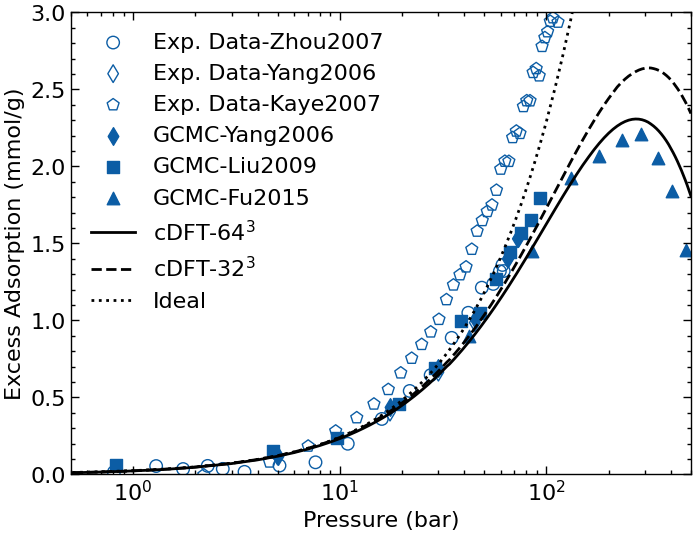

In [ ]:
plt.rcParams["lines.markersize"] = 9

plt.scatter(exp_data_exc['P(bar)-300K'],(1e3/mss)*(mss/mff)*exp_data_exc['Nexc(%wt)-300K']*0.01/(1-exp_data_exc['Nexc(%wt)-300K']*0.01),marker='o',edgecolors='C0',facecolors='none',label='Exp. Data-Zhou2007')

plt.scatter(exp_data2['Pressure (MPa)']*10,exp_data2['Excess adsorption (mmol/g)'],marker='d',edgecolors='C0',facecolors='none',label='Exp. Data-Yang2006')

plt.scatter(exp_data2p5['P (bar)'],(1e3/mss)*(mss/mff)*exp_data2p5['Excess H2 adsorbed (wt %)']*0.01/(1-exp_data2p5['Excess H2 adsorbed (wt %)']*0.01),marker='p',edgecolors='C0',facecolors='none',label='Exp. Data-Kaye2007')

plt.scatter(exp_data2['Pressure (MPa)']*10,exp_data2['Sim Excess adsorption (mmol/g)'],marker='d',edgecolors='C0',facecolors='C0',label='GCMC-Yang2006')

# #convert from absolute to excess
rhobarray_data3 = rhofromBARpressure300K(exp_data3['Pressure (bar)'])
Nabs_data3 = (mss/mff)*exp_data3['Absolute adsorption (%w.t.)']*0.01/(1-exp_data3['Absolute adsorption (%w.t.)']*0.01)
Nexc_data3 = Nabs_data3 - rhobarray_data3*Vpore
plt.scatter(exp_data3['Pressure (bar)'],1e3*Nexc_data3/mss,marker='s',edgecolors='C0',facecolors='C0',label='GCMC-Liu2009')

#convert from absolute to excess
rhobarray_data4 = rhofromBARpressure300KWu(exp_data4['Pressure (bar)'])
Nabs_data4 = exp_data4['Absolute adsorption (cm^3 STP/cm^3)']/(1e30*(kB*298.15/101325)/Vcell) # Fu and Wu uses 25ºC and 1 atm as STP?!!?!?
Nexc_data4 = Nabs_data4 - rhobarray_data4*Vpore
plt.scatter(exp_data4['Pressure (bar)'],1e3*Nexc_data4/mss,marker='^',edgecolors='C0',facecolors='C0',label='GCMC-Fu2015')

# plt.scatter(exp_data5['Pressure (bar)'],exp_data5['Excess adsorption (mmol/g)'],marker='v',edgecolors='C0',facecolors='C0',label='GCMC-Keskin2016')

plt.plot(dft300K_data['Pressure (bar)'],dft300K_data['Excess adsorption (mol/kg)'],'-',color='k',label='cDFT-64$^3$')

plt.plot(dft300K_data32['Pressure (bar)'],dft300K_data32['Excess adsorption (mol/kg)'],'--',color='k',label='cDFT-32$^3$')

plt.plot(dft300K_data['Pressure (bar)'],dft300K_data['Ideal adsorption (mol/kg)']-dft300K_data['Bulk adsorption (mol/kg)'],':',color='k',label='Ideal')

# plt.plot(df['Pressure (bar)'],df['Excess adsorption (mol/kg)'],'-',color='r',label='cDFT-128$^3$')

plt.legend(loc='upper left')
plt.xlabel('Pressure (bar)')
plt.ylabel('Excess Adsorption (mmol/g)')
plt.xlim(0.5,500)
plt.ylim(0,3)
# plt.yscale('log')
plt.xscale('log')